# Creating records 
## Pipeline 2.0
##### ASTROMER dev team

*Feb 27 2024*

In [1]:
cd ../..

/home/cridonoso/Documents/astromer-science/astromer


In [3]:
import matplotlib.pyplot as plt
import polars as pl
import numpy as np
import os

from src.data.record import DataPipeline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Describing raw data before record creation

In [ ]:
metadata = pl.read_parquet('./data/raw_data_parquet/macho/metadata.parquet')
single_md = metadata.filter(pl.col('shard') == 0)

In [30]:
a = metadata.filter(pl.col('ID') == metadata.sample()['ID'])#'F_10.4164.1843')
a

ID,Path,N,Band,Class,sset,newID,path,Label,shard
str,str,i64,str,str,str,i64,str,i8,i64
"""F_103.24681.20…","""F_103.24681.20…",282,"""R""","""NonVar""","""train""",574087,"""data/raw_data/…",0,57


In [104]:
# single_md.to_pandas().to_parquet('./data/raw_data_parquet/tinymacho/metadata.parquet')

(784, 5)
F_10.4275.3723
(814, 5)


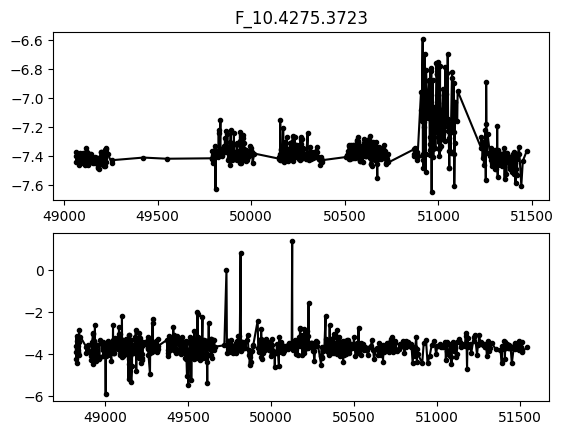

In [150]:
fig, axes = plt.subplots(a.shape[0], 1)
for i, row in enumerate(a.rows()):
    shard_name = str(row[-1]).rjust(3, '0')
    
    observations = pl.read_parquet('./data/raw_data_parquet/macho/light_curves/shard_{}.parquet'.format(shard_name))
    curve = observations.filter(pl.col('newID') == row[-4])
    print(curve.shape)
    axes[i].plot(curve['mjd'], curve['mag'], marker='.', color='k')
    if i == 0:
        axes[i].set_title(row[0])
        print(row[0])
    

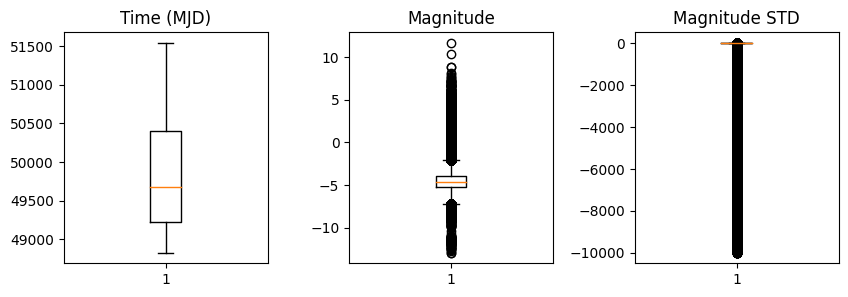

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3), gridspec_kw={'wspace':0.4}, dpi=100)
axes[0].boxplot(observations['mjd'])
axes[0].set_title('Time (MJD)')
axes[1].boxplot(observations['mag'])
axes[1].set_title('Magnitude')
axes[2].boxplot(observations['errmag'])
axes[2].set_title('Magnitude STD')
plt.show()

In [73]:
def lightcurve_step(inputs):
    p99 = inputs.quantile(0.95, 'nearest')
    p01 = inputs.quantile(0.05, 'nearest')
    inputs = inputs.filter(pl.col('mag') < p99['mag'])
    inputs = inputs.filter(pl.col('mag') > p01['mag'])
    return inputs
    
observations_f = observations.filter((pl.col('errmag') > 0)\
                                     & (pl.col('errmag') < 1.) \
                                     & (pl.col('errmag') < pl.col('mag').abs()))

observations_f = observations_f.group_by('newID').apply(lightcurve_step)

observations_f.shape[0]/observations.shape[0]

/tmp/ipykernel_3614767/839042409.py:12: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_groups`.
  observations_f = observations_f.group_by('newID').apply(lightcurve_step)


0.8497722736944622

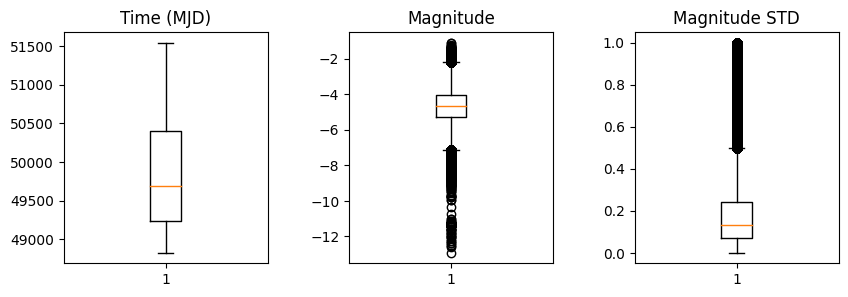

In [67]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3), gridspec_kw={'wspace':0.4}, dpi=100)
axes[0].boxplot(observations_f['mjd'])
axes[0].set_title('Time (MJD)')
axes[1].boxplot(observations_f['mag'])
axes[1].set_title('Magnitude')
axes[2].boxplot(observations_f['errmag'])
axes[2].set_title('Magnitude STD')
plt.show()

## Creating records

In [5]:
METAPATH = './data/raw_data_parquet/alcock/metadata.parquet'
OBSPATH  = './data/raw_data_parquet/alcock/light_curves/'
config_path = './data/raw_data_parquet/alcock/config.toml'

In [6]:
metadata = pd.read_parquet(METAPATH)

In [7]:
metadata['Class'] = pd.Categorical(metadata['Class'])
metadata['Label'] = metadata['Class'].cat.codes
metadata['Path'] = metadata['Path'].apply(lambda x: os.path.join(OBSPATH, x)) 

In [8]:
metadata.sample()

,ID,Class,Path,Band,sset,newID,Label
9,78.5859.18,Cep_0,./data/raw_data_parquet/alcock/light_curves/78...,1.0,train,15693,0


### Using DataPipeline class

In [9]:
# Create an instance of DataPipeline
pipeline = DataPipeline(metadata=metadata,
                        config_path=config_path)

[INFO] 20 samples loaded


In [10]:
pipeline.sequential_features_dtype

['float', 'float', 'float']

To create training, validation, and testing splits we need to use the `train_val_test` method 
```
train_val_test(val_frac=0.2,
               test_frac=0.2,
               test_meta=None,
               val_meta=None,
               shuffle=True,
               id_column_name=None,
               k_fold=1)
``` 
where `val_frac` and `test_frac` are percentages containing the fraction of the metadata to be used as validation and testing subset respectively. 

Additionally, you can use `val_meta` and `test_meta` to use a preselected subset. **Notice that if you employ your own test/val subset, you should match one of the identifier columns of the main DataFrame** (by default it will assume the first column of the dataset is the identifier). 

Both `test_meta` and `val_meta` must be list of `DataFrames`

For cross-validation purposes, we can also sample different folds from the same dataset by using the `train_val_test(..., k_fold=1)` parameter.

If $k>1$ and **you want to use a predefined test/val selection**, you should pass a list of `DataFrame`s associated with each `test_meta`/`val_meta` fold as appropriate.

Don't worry about removing duplicated indices, the `train_val_test` method will do it for you.

In [11]:
# test_metadata = metadata.sample(n=100)
test_metadata = metadata[metadata['sset'] == 'test']

In [14]:
k_folds = 3
pipeline.train_val_test(val_frac=0.2, 
                        test_meta=None, 
                        k_fold=k_folds)

[INFO] Using ID col as sample identifier
[INFO] Shuffling
[INFO] Shuffling
[INFO] Shuffling


In [15]:
a = pipeline.metadata['subset_0']
for k in range(k_folds):
    if k == 0: continue
    b = pipeline.metadata[f'subset_{k}']
    c = np.array_equal(a[a != 'test'].values, b[b!= 'test'].values)
    a = b
    print('Do {}-folds partitions have the same elements: '.format(k_folds), c)

Do 3-folds partitions have the same elements:  False
Do 3-folds partitions have the same elements:  False


Now our metadata will contain an extra-column `subset` for the corresponding subset

In [18]:
pipeline.metadata.sample(4)

,ID,Class,Path,Band,sset,newID,Label,subset_0,subset_1,subset_2
13,23.3062.469,RRc,./data/raw_data_parquet/alcock/light_curves/23...,1.0,train,8121,4,test,test,train
2,82.8408.718,RRab,./data/raw_data_parquet/alcock/light_curves/82...,1.0,train,20001,3,train,train,train
18,10.3560.324,RRc,./data/raw_data_parquet/alcock/light_curves/10...,1.0,train,961,4,test,train,train
9,78.5859.18,Cep_0,./data/raw_data_parquet/alcock/light_curves/78...,1.0,train,15693,0,train,train,validation


In [19]:
for k in range(k_folds):
    train_subset = pipeline.metadata[pipeline.metadata[f'subset_{k}'] == 'train']
    val_subset   = pipeline.metadata[pipeline.metadata[f'subset_{k}'] == 'validation']
    test_subset  = pipeline.metadata[pipeline.metadata[f'subset_{k}'] == 'test']

    print(train_subset.shape, val_subset.shape, test_subset.shape)

    print('test in train?: ', test_subset['ID'].isin(train_subset['ID']).all(),'\n',
          'val in train?: ', val_subset['ID'].isin(train_subset['ID']).all(),'\n',
          'val in test?: ', val_subset['ID'].isin(test_subset['ID']).all())

(13, 10) (3, 10) (4, 10)
test in train?:  False 
 val in train?:  False 
 val in test?:  False
(13, 10) (3, 10) (4, 10)
test in train?:  False 
 val in train?:  False 
 val in test?:  False
(13, 10) (3, 10) (4, 10)
test in train?:  False 
 val in train?:  False 
 val in test?:  False


Notice if you want to redo, you must initialize the object `DataPipeline` again

Now it is **time to the pipeline**

In [22]:
pipeline.context_features, pipeline.context_features_dtype

(['ID', 'Label', 'Class', 'Band'], ['string', 'integer', 'string', 'integer'])

In [ ]:
%%time
var = pipeline.run(observations_path=OBSPATH, 
                   metadata_path=METAPATH,
                   n_jobs=8,
                   elements_per_shard=5000)

### Customize what happens within the preprocess function

You must keep the same parameters of the method i.e., `row, context_features, sequential_features`. 

Also the **output** should be tuple containing the lightcurve (`pd.DataFrame`) and the context values (`dict`)


To modify the `process_sample` method we need to create a new class (`MyPipeline`) that inherits from `DataPipeline` 

In [34]:
import polars as pl
class MyPipeline(DataPipeline):
    def lightcurve_step(self, inputs):
        """
        Preprocessing applied to each light curve separately
        """
        # First feature is time
        inputs = inputs.sort(self.sequential_features[0], descending=True) 
        print(inputs)
        return inputs

    def observations_step(self):
        """
        Preprocessing applied to all observations. Filter only
        """
        fn_0 = pl.col("red error") <1.  # Clean the data on the big lazy dataframe
        fn_1 = pl.col("red magnitude") <2.
        return fn_0 & fn_1

Next steps are the same as using the original `DataPipeline` class

In [35]:
custom_pipeline = MyPipeline(metadata=metadata,
                             config_path=config_path)

[INFO] 1529386 samples loaded


In [36]:
test_metadata = metadata.sample(n=100)
k_folds = 3
custom_pipeline.train_val_test(val_frac=0.2, 
                               test_meta=[test_metadata]*k_folds, 
                               k_fold=k_folds)

[INFO] Using ID col as sample identifier
[INFO] Shuffling
[INFO] Shuffling
[INFO] Shuffling


In [ ]:
%%time
var = custom_pipeline.run(observations_path=OBSPATH, 
                           metadata_path=METAPATH,
                           n_jobs=8,
                           elements_per_shard=5000)

2024-02-23 20:45:11,747 - INFO - Starting DataPipeline operations



  0%|                                                                                                                                              | 0/3 [00:00<?, ?it/s]

# Reading

In [56]:
import tensorflow as tf
from src.data.loaders import get_loader
from src.data.zero import pretraining_pipeline
import glob
import os

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
root = './data/records/alcock/fold_0/alcock/train/'
window_size = 200
probed_frac = .5
random_frac = 0.8
same_frac = 0.2

In [59]:
dataset = get_loader(root, 
                     window_size=window_size,
                     batch_size=16,
                     probed_frac=probed_frac,
                     random_frac=random_frac,
                     same_frac=0.2,
                     shuffle=False,
                     sampling=False,
                     aversion='base',
                     normalize='zero-mean',)

[INFO] Probed: 0.50 Random: 0.80 Same: 0.20
[INFO] Repeating dataset x1 times
[INFO] Loading PT task: Masking


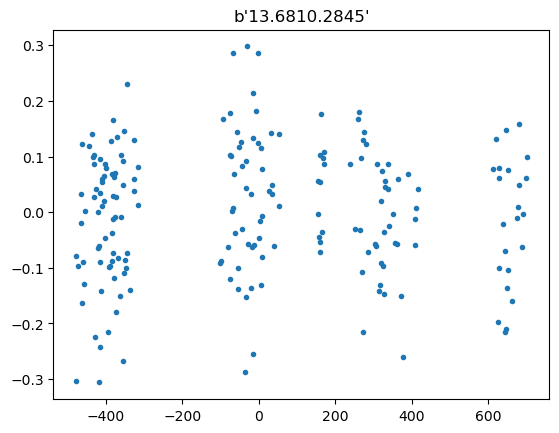

In [52]:
for x, y in dataset.take(1):
    plt.title(y['lcid'][0].numpy())
    xinp = tf.boolean_mask(x['input'][0], 1.-x['mask_in'][0])
    tinp = tf.boolean_mask(x['times'][0], 1.-x['mask_in'][0])
    plt.plot(tinp, xinp, marker='.', linestyle='')

In [14]:
zero_loader = pretraining_pipeline(root,
                                    batch_size= 16, 
                                    window_size=window_size,
                                    shuffle=False,
                                    sampling=False,
                                    repeat=1,
                                    msk_frac=probed_frac,
                                    rnd_frac=random_frac,
                                    same_frac=random_frac)

[INFO] Repeating dataset x1 times
[INFO] Loading PT task: Masking


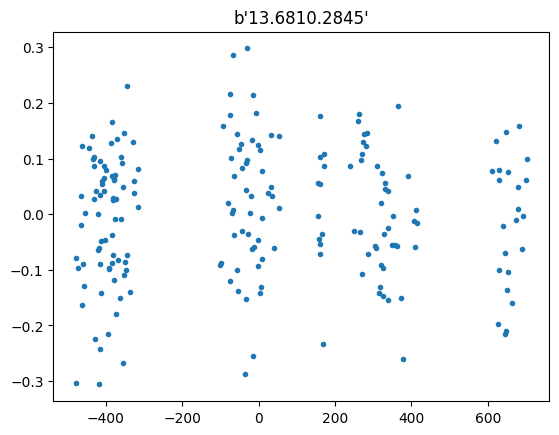

In [51]:
for x, y in zero_loader.take(1):
    plt.title(y['lcid'][0].numpy())
    xinp = tf.boolean_mask(x['input'][0], 1.-x['mask_in'][0])
    tinp = tf.boolean_mask(x['times'][0], 1.-x['mask_in'][0])
    plt.plot(tinp, xinp, marker='.', linestyle='')